<a href="https://colab.research.google.com/github/bida22-070/BIDA22-070/blob/main/An_Ethical_AI_Based_Dynamic_Pricing_Model_for_Retail_Businesses_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CET313 ARTIFICIAL INTELLIGENCE-PROTOTYPE DEVELOPMENT

**Student Name:** Maipelo Yame Chloe Rakgomo                        
**Student ID:** bj                   
**Assignment Title:** An Ethical AI-Powered Dynamic Pricing Framework For Retail Businesses      
**Date:** 12/12/2025

#Introduction
This project builds an ethical AI-powered dynamic pricing system and it uses a real retail dataset from Kaggle.Product details,prices,demand,inventory levels,competitor pricing,weather and seasonal factors are all included in the dataset.
The objective is to:                 
-Use machine learning to predict demand(Random Forest & Linear Regression).                        
-Based on estimated revenue suggest the best prices.                     
-Use ethical guidelines to avoid unfair or exploiting prices.

Data loading,pre-processing feature engineering,model training,pricing optimisation and fairness assessment are included in the notebook


#1.Necessary libraries
Import all necessary libraries required for data handling,visualisation and machine learning

In [2]:
#Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

#Machine learning
from sklearn.model_selection import train_test_split #used to split datasets into training and testing subsets(EMP)
from sklearn.ensemble import RandomForestRegressor #ML algorithm;combines multiple decision trees to create a more accurate and stable regression model
from sklearn.linear_model import LinearRegression #statistical method that models the relationship between variables using a linear equation
from sklearn.metrics import mean_absolute_error, r2_score #Measures the average absolute difference between predicted and actual values/r2(coefficient of determination measures performance of the regression model)  measures how well the model explains the variance in the target variable
from sklearn.preprocessing import OneHotEncoder, StandardScaler #Converts categorical variables into binary (0/1) columns/StandardScaler Standardizes features by removing the mean and scaling to unit variance
from sklearn.pipeline import Pipeline #helps create reproducible workflows and prevents data leakage.

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) #ensures that any random operations performed by NumPy will be reproducible

print('libraries loaded')

libraries loaded


#2.Load then Inspect Dataset
Load dataset into notebook and assess dataset structure,check for errors

In [3]:
#Upload dataset
from google.colab import files
uploaded = files.upload()
#Uploads dataset manually
df = pd.read_csv(list(uploaded.keys())[0])
df.head()
#Structure of the dataset
df.head()
df.info()
df.isnull().sum()

Saving retail_store_inventory.csv to retail_store_inventory.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  ob

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


#3.Data Preparation
Prepare dataset for modelling

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(['product_id','date']).reset_index(drop=True)
print("Date range:", df['date'].min(), "to", df['date'].max())
display(df.head())

Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00


,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,demand_forecast,price,discount,weather_condition,holiday_promotion,competitor_pricing,seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S002,P0001,Groceries,South,343,104,144,112.55,32.80,20,Sunny,1,30.78,Spring
2,2022-01-01,S003,P0001,Toys,South,241,147,180,161.09,67.21,5,Sunny,1,67.39,Summer
3,2022-01-01,S004,P0001,Toys,South,477,271,66,286.65,15.62,15,Sunny,0,16.09,Winter
4,2022-01-01,S005,P0001,Toys,West,111,77,60,83.47,70.33,10,Cloudy,0,70.29,Winter


#4.Feature Engineering
Engineer predictive features that enhance machine learning model

In [5]:
#Lag Features(Generates missing values first few days of each product)
#captures trends and seasonality
df['units_sold_lag1'] = df.groupby('product_id')['units_sold'].shift(1) #yesterday's demand
df['units_sold_lag7'] = df.groupby('product_id')['units_sold'].shift(7) #lastweek's demand

df['rolling_avg_7'] = (
    df.groupby('product_id')['units_sold']
    .rolling(7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
) #7day moving average,helps model understand meduim-term demand patterns
#Price features
df['price_competitor_ratio'] = df['price'] / (df['competitor_pricing'] + 1e-6)
df['discount_flag'] = (df['discount'] > 0).astype(int) #predictors of sales
#Time features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month #demand varies by day of week/month
#Drop rows with Na from lagging for clean dataset
df = df.dropna().reset_index(drop=True)
#Cleaned columns
df.columns
df.head()
#Tells the model what happened in the past/Can be short term or long term

,date,store_id,product_id,category,region,inventory_level,units_sold,units_ordered,demand_forecast,price,...,holiday_promotion,competitor_pricing,seasonality,units_sold_lag1,units_sold_lag7,rolling_avg_7,price_competitor_ratio,discount_flag,day_of_week,month
0,2022-01-02,S003,P0001,Toys,West,277,114,40,132.41,73.48,...,0,72.55,Autumn,343.0,127.0,162.428571,1.012819,1,6,1
1,2022-01-02,S004,P0001,Electronics,North,144,22,45,39.12,74.16,...,0,69.74,Autumn,114.0,104.0,150.714286,1.063378,1,6,1
2,2022-01-02,S005,P0001,Groceries,East,223,67,53,74.80,67.49,...,0,65.24,Winter,22.0,147.0,139.285714,1.034488,1,6,1
3,2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,...,0,58.22,Winter,67.0,271.0,101.285714,1.076949,1,0,1
4,2022-01-03,S002,P0001,Toys,North,405,96,171,100.82,48.08,...,1,49.40,Autumn,5.0,77.0,104.000000,0.973279,0,0,1


In [9]:
#Select features and Target variables for forecasting demand
feature_cols = [
    'price', 'discount', 'competitor_pricing', 'inventory_level',
    'units_sold_lag1', 'units_sold_lag7', 'rolling_avg_7',
    'price_competitor_ratio', 'discount_flag',
    'day_of_week', 'month',
    'category', 'region', 'weather_condition', 'seasonality'
]

target = 'units_sold' # predicting units sold which demand(matches real world retail features)


#5.Train/Test Split
Split dataset into;80%training data and 20%testing data
Allows to train model on one section of the data and evaluate performance on another section to avoid overfitting

In [10]:
#Split data into train/test
X = df[feature_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print("Train rows:", len(X_train), "Test rows:", len(X_test))
#ensures reproducibility
#80% training and 20% testing data

Train rows: 58368 Test rows: 14592


#6.Preprocessing Pipeline
Used column transformer to make sure machine learning model can read text-based features.The pipeline keeps preprocessing consistent during training and prediction.

In [11]:
#Preprocessing and models
from sklearn.compose import ColumnTransformer

#Identify categorical vs numeric columns
categorical_cols = ['category', 'region', 'weather_condition', 'seasonality']
numeric_cols = [col for col in feature_cols if col not in categorical_cols]
#Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)
#Ensures clean input into the ML model

#7.Model Training
Linear regression as the baseline.Evaluation is done using MAE and r2

In [12]:
#Training model:Linear regression(used to model the relationship between target and predictors)
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, lr_preds))
print("Linear Regression R² :", r2_score(y_test, lr_preds))
#MAE = 65 units → model off by 65 units on average
#R² = 0.43 → model explains 43% of demand patterns
#Performance is moderate.

Linear Regression MAE: 65.00615032526402
Linear Regression R² : 0.43027703900619085


We train a Random Forest model to capture complex non-linear relationships between features and demand.
Random Forest usually performs better because it builds many decision trees.

We compare its MAE and R² to the Linear Regression model.

In [13]:
#Model 2 Random Forest Regression
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=25,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest R² :", r2_score(y_test, rf_preds))
#MAE = 62.4 units → better than Linear Regression
#R² = 0.45 → explains 45% of demand variability
#Random Forest performs better, so it is selected as the pricing engine.

Random Forest MAE: 62.41181662900361
Random Forest R² : 0.45409473002870715


Random Forest is the best model because it has lower prediction error and explain more variability in demand.

In [14]:
#Best performing model
best_model = rf_model   # Usually Random Forest performs better(Understanding its prediction and performance)
print(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['price', 'discount',
                                                   'competitor_pricing',
                                                   'inventory_level',
                                                   'units_sold_lag1',
                                                   'units_sold_lag7',
                                                   'rolling_avg_7',
                                                   'price_competitor_ratio',
                                                   'discount_flag',
                                                   'day_of_week', 'month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category', 'region',
                              

#8.Ethical Pricing Features
Before suggesting a price,fairness check has to be done
price must not exceed category median thresholds

surge limits prevent unfair increases

prices should not fall below cost

bias checks compare fairness across categories

each product gets a compliance label (fair/unfair)

In [15]:
#Ethical functions
median_price_by_category = df.groupby('category')['price'].median().to_dict()
overall_median_price = df['price'].median()
print("Categories:", list(median_price_by_category.keys()))
print("Overall median price:", overall_median_price) #Compute category medians used to limit excessive category pricing.

def optimize_price_for_row(row, model_pipeline, feature_cols, price_candidates_pct=np.linspace(-0.25,0.25,11)):
    base_price = float(row['price'])
    best = {'price': base_price, 'pred_demand': None, 'revenue': -np.inf}
    for pct in price_candidates_pct:
        candidate_price = max(0.01, base_price * (1 + float(pct)))
        x = {}
        for c in feature_cols:
            if c == 'price':
                x[c] = candidate_price
            elif c == 'price_competitor_ratio':
                x[c] = candidate_price / (row['competitor_pricing'] + 1e-6)
            elif c == 'discount_flag':
                x[c] = int(row.get('discount', 0) > 0)
            else:
                x[c] = row[c]
        xdf = pd.DataFrame([x])
        pred_d = model_pipeline.predict(xdf)[0]
        pred_d = max(0.0, float(pred_d))
        revenue = candidate_price * pred_d
        if revenue > best['revenue']:
            best = {'price': round(candidate_price,2), 'pred_demand': pred_d, 'revenue': revenue}
    return best

def apply_ethics(recommendation, row, median_price_by_category, cap_pct=0.30, max_surge_pct=0.25):
    cat_med = median_price_by_category.get(row['category'], row['price'])
    price = float(recommendation['price'])
    reasons = []
    complied = True
    max_allowed = cat_med * (1 + cap_pct)
    if price > max_allowed:
        complied = False
        reasons.append('exceeds_category_median_cap')
        price = round(max_allowed, 2)
    max_surge = float(row['price']) * (1 + max_surge_pct)
    if price > max_surge:
        complied = False
        reasons.append('exceeds_max_surge_over_historical')
        price = round(min(price, max_surge), 2)
    if 'base_cost' in row.index:
        floor = row['base_cost'] * 1.05
        if price < floor:
            complied = False
            reasons.append('minumum_pricing')
            price = round(floor,2)
    price = max(price, 0.01)
    return {'final_price': price, 'complied': complied, 'reasons': reasons}


Categories: ['Clothing', 'Electronics', 'Furniture', 'Groceries', 'Toys']
Overall median price: 55.04


Apply Ethical Rules
We apply fairness constraints to the AI-recommended price.
If the price is unfair, it is adjusted down (or up) and the reasons are recorded.

The output shows:

historical price

AI-recommended price

final ethical price

explanation of adjustments

In [19]:
#Ethical Rules
def apply_ethics(recommendation, row, median_price_by_category, cap_pct=0.30, max_surge_pct=0.25):
    """
    Apply rule-based ethical constraints:
    - cap relative to category median (cap_pct)
    - cap surge over historical price (max_surge_pct)
    - enforce cost floor if 'base_cost' present
    Returns dict with 'final_price', 'complied' (bool), and 'reasons'.
    """
    cat_med = median_price_by_category.get(row['category'], row['price'])
    price = float(recommendation['price'])
    reasons = []
    complied = True

    # Rule 1: cap relative to category median
    max_allowed = cat_med * (1 + cap_pct)
    if price > max_allowed:
        complied = False
        reasons.append('exceeds_category_median_cap')
        price = round(max_allowed, 2)

    # Rule 2: surge cap relative to historical price
    max_surge = float(row['price']) * (1 + max_surge_pct)
    if price > max_surge:
        complied = False
        reasons.append('exceeds_max_surge_over_historical')
        price = round(min(price, max_surge), 2)

    # Rule 3: floor = cost * 1.05 (if base_cost available)
    if 'base_cost' in row.index:
        floor = row['base_cost'] * 1.05
        if price < floor:
            complied = False
            reasons.append('below_cost_floor')
            price = round(floor, 2)

    price = max(price, 0.01)
    return {'final_price': price, 'complied': complied, 'reasons': reasons}


Create a bar chart showing compliance percentages by product category.It helps identify which categories that may violate fairness rules more often.

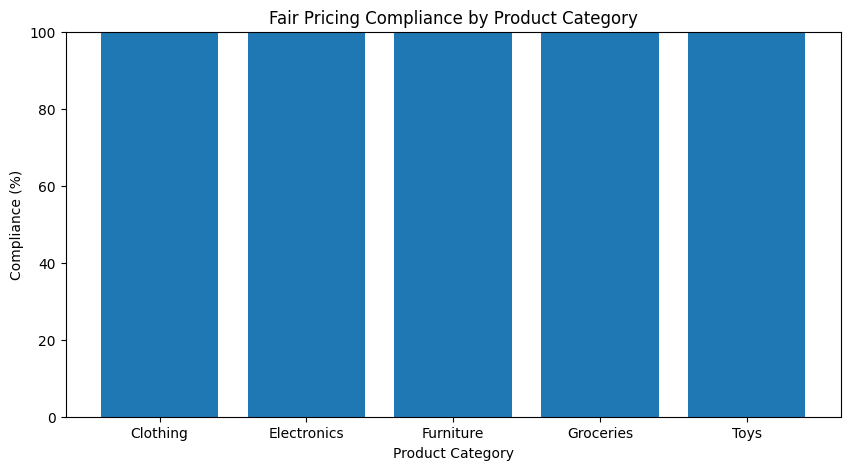

In [23]:
#Category Compliance bar chart
category_compliance = (
    sim_results_df.groupby('category')['complied']
    .mean()
    .reset_index()
)
category_compliance['compliance_pct'] = category_compliance['complied'] * 100

plt.figure(figsize=(10,5))
plt.bar(category_compliance['category'], category_compliance['compliance_pct'])
plt.title("Fair Pricing Compliance by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Compliance (%)")
plt.ylim(0,100)
plt.show()


In [25]:
#Ethical simulation(50-1000items)
import random
sample_indices = X_test.index.to_list()
sample_size = 50
sample_indices_sampled = random.sample(sample_indices, min(sample_size, len(sample_indices)))
simulation_df = df.loc[sample_indices_sampled].copy().reset_index(drop=True)

results = []
for index, row in simulation_df.iterrows():
    historical_price = row['price']
    competitor_pricing = row['competitor_pricing']
    category = row['category']
    product_id = row['product_id']

    price_options = historical_price * np.linspace(0.9, 1.1, 5)
    best_demand = -1
    optimal_price = historical_price

    temp_row_data = row[feature_cols].copy().to_dict()

    for p in price_options:
        temp = temp_row_data.copy()
        temp['price'] = p
        temp['price_competitor_ratio'] = p / (competitor_pricing + 1e-6)
        for col in feature_cols:
            if col not in temp:
                temp[col] = row[col]
        try:
            pred_demand = best_model.predict(pd.DataFrame([temp]))[0]
            if pred_demand > best_demand:
                best_demand = pred_demand
                optimal_price = p
        except Exception as e:
            optimal_price = historical_price
            break

    recommended_price = optimal_price

    ethical_threshold = 0.15
    final_price = recommended_price
    reasons = "No adjustment needed"
    complied = True

    if recommended_price > historical_price * (1 + ethical_threshold):
        final_price = historical_price * (1 + ethical_threshold)
        reasons = f"Adjusted down for ethical reasons (recommended price was {recommended_price:.2f}, capped at {final_price:.2f})"
        complied = False
    elif recommended_price < historical_price * 0.8:
        final_price = historical_price * 0.8
        reasons = f"Adjusted up to prevent significant loss (recommended price was {recommended_price:.2f}, floored at {final_price:.2f})"
        complied = False

    results.append({
        'product_id': product_id,
        'category': category,
        'historical_price': historical_price,
        'recommended_price': recommended_price,
        'final_price': final_price,
        'reasons': reasons,
        'complied': complied
    })

sim_results_df = pd.DataFrame(results)
print("Generated sim_results_df with ethical pricing simulations:", len(sim_results_df))
display(sim_results_df.head())
#shows product, historical price, recommended, final ethical price, reasons column.


Generated sim_results_df with ethical pricing simulations: 50


,product_id,category,historical_price,recommended_price,final_price,reasons,complied
0,P0017,Clothing,22.78,20.5020,20.5020,No adjustment needed,True
1,P0007,Groceries,72.91,72.9100,72.9100,No adjustment needed,True
2,P0002,Groceries,95.81,100.6005,100.6005,No adjustment needed,True
3,P0018,Electronics,97.00,101.8500,101.8500,No adjustment needed,True
4,P0009,Furniture,87.36,87.3600,87.3600,No adjustment needed,True


The histogram shows whether the ethical system stabilises pricing

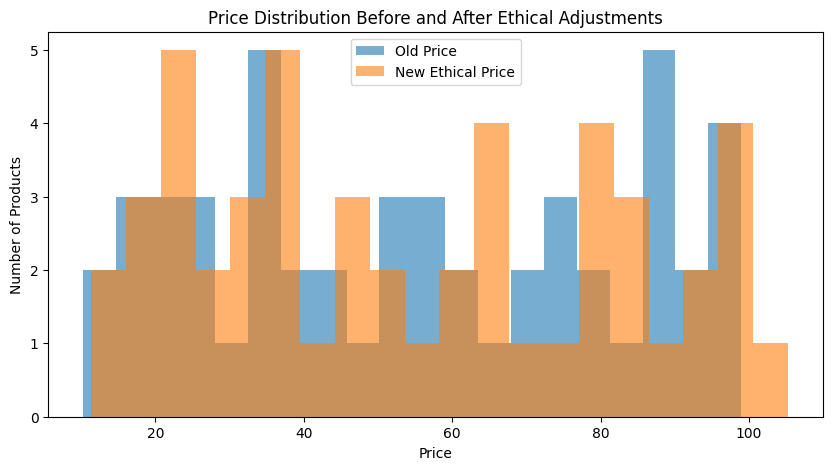

In [25]:
#A histogram to show before vs after(Original historical price vs new ethical prices)
plt.figure(figsize=(10,5))
plt.hist(sim_results_df['historical_price'], bins=20, alpha=0.6, label='Old Price')
plt.hist(sim_results_df['final_price'], bins=20, alpha=0.6, label='New Ethical Price')
plt.title("Price Distribution Before and After Ethical Adjustments")
plt.xlabel("Price")
plt.ylabel("Number of Products")
plt.legend()
plt.show()


Plot shows how predicted demand changes as price increases.Helps business managers understand price sensitivity and behaviour of the model.

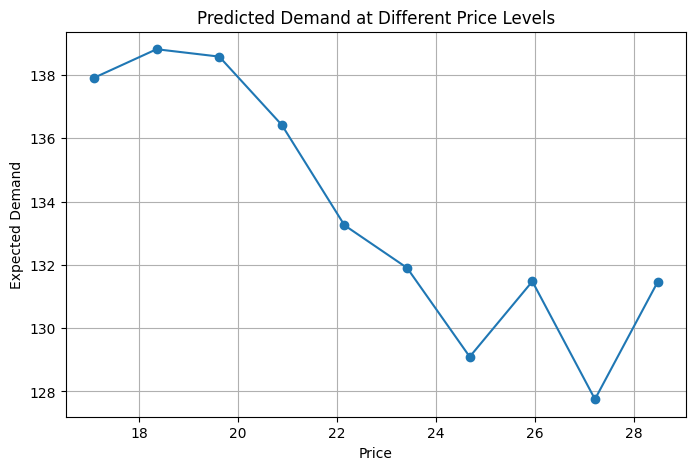

In [26]:
#Price vs demand plot
def plot_price_vs_demand(row):
    base_price = row['price']
    price_range = base_price * np.linspace(0.75, 1.25, 10)
    demands = []
    for p in price_range:
        temp = row.copy()
        temp['price'] = p
        temp['price_competitor_ratio'] = p / (row['competitor_pricing'] + 1e-6)
        temp_dict = {c: temp[c] if c in temp.index else row[c] for c in feature_cols}
        pred = best_model.predict(pd.DataFrame([temp_dict]))[0]
        demands.append(max(0, pred))

    plt.figure(figsize=(8,5))
    plt.plot(price_range, demands, marker='o')
    plt.title("Predicted Demand at Different Price Levels")
    plt.xlabel("Price")
    plt.ylabel("Expected Demand")
    plt.grid(True)
    plt.show()

plot_price_vs_demand(simulation_df.iloc[0])
#show how demand changes with price for a single product

In [1]:
#An explanation table(Front-end user)
explanation_df = sim_results_df[['product_id','historical_price','recommended_price','final_price','reasons']].copy()
explanation_df.rename(columns={
    'product_id': 'Product',
    'historical_price': 'Current Price',
    'recommended_price': 'AI Price',
    'final_price': 'Ethical Price',
    'reasons': 'Reason for Adjustment'
}, inplace=True)

explanation_df.head(10)
#it lists the AI price, ethical-adjusted price and reasons which is important for business user,audit and trust.

NameError: name 'sim_results_df' is not defined

This business summary function is designed for non-tech users like the retail managers.

In [28]:
def business_summary_row(row):
    print("ETHICAL PRICING SUMMARY")
    print(f"Product ID: {row['product_id']}")
    print(f"Category: {row.get('category','')}, Region: {row.get('region','')}\\n")
    print(f"Historical Price: ${row['historical_price']:.2f}")
    print(f"AI Recommended Price: ${row['recommended_price']:.2f}")
    print(f"Final Ethical Price: ${row['final_price']:.2f}\\n")
    if row['complied']:
        print('✔ The recommended price follows all ethical rules.')
    else:
        print('⚠ Price adjusted due to fairness rules.')
        print('Reasons:')
        print(' -', row['reasons'])
    print(f"\\nPredicted Demand (at AI price): {row.get('predicted_demand_at_rec', 'N/A')}")

business_summary_row(sim_results_df.iloc[0])


ETHICAL PRICING SUMMARY
Product ID: P0020
Category: Clothing, Region: \n
Historical Price: $24.89
AI Recommended Price: $24.89
Final Ethical Price: $24.89\n
✔ The recommended price follows all ethical rules.
\nPredicted Demand (at AI price): N/A


This model maximises profit and enforces fairness
It has 3 sections
1.A demand prediction part-predicts customer's demand and uses machine learning random forest to learn patterns from the past and predict.This is important because we can't choose a price without knowing how people will respond.
2.A pricing part-tries out several possible prices,for each price it asks the demand brain the calculates revenue(price*predicted sales) then picks orice that will make most money based on demand
3.An ethics part-is the price fair and responsible
*Price cannot exceed a certain limit above the category median price.
*Price cannot jump too fast compared to yesterday’s price.
*Price cannot drop below cost + 5%.
If a price violates any rule:
-the ethics brain adjusts it
-and gives a reason, like:

“exceeds_category_median_cap”
“exceeds_max_surge_over_historical”
“below_cost_floor”

So the final price is always:
-Fair
-Safe
-Ethical
-Still profit-focused
RESULTS
Historical price
AI recommended price
Final ethical price
Reasons for adjustment (if any)
Compliance score
Demand predictions
Revenue improvements
Visual dashboards:
Price changes
Ethical compliance by category
Before/after histograms
Price vs demand curve

The model predicts future demand using machine learning(random forest), tests multiple price options, selects the most profitable one, then applies rule-based ethical constraints to ensure fairness before producing the final price.